In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download data from kaggle

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
# !kaggle datasets download -d adityajn105/flickr8k

 99% 1.03G/1.04G [00:04<00:00, 263MB/s]
100% 1.04G/1.04G [00:04<00:00, 248MB/s]


In [ ]:
# !cp /content/flickr8k.zip /content/drive/MyDrive/CS336/data

In [ ]:
# !unzip "/content/drive/MyDrive/CS336/data/flickr8k.zip" -d "/content/drive/MyDrive/CS336/data"

## Install CLIP

In [ ]:
%cd /content/drive/MyDrive/CS336

/content/drive/MyDrive/CS336


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-24adkh6a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-24adkh6a
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


## Using

In [ ]:
import torch
import clip
from PIL import Image
from torchvision.datasets import CIFAR100
import os
import pandas as pd

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

## Zero-Shot Prediction Pic to Text

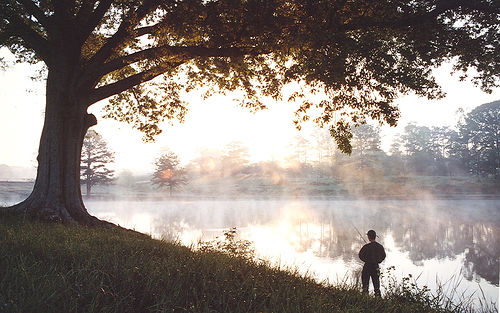

In [ ]:
img = Image.open("/content/drive/MyDrive/CS336/data/Images/17273391_55cfc7d3d4.jpg")
img

In [ ]:
data_text = pd.read_csv('/content/drive/MyDrive/CS336/data/captions.txt')

In [ ]:
data_text.caption

0        A child in a pink dress is climbing up a set o...
1                    A girl going into a wooden building .
2         A little girl climbing into a wooden playhouse .
3        A little girl climbing the stairs to her playh...
4        A little girl in a pink dress going into a woo...
                               ...                        
40450             A man in a pink shirt climbs a rock face
40451             A man is rock climbing high in the air .
40452    A person in a red shirt climbing up a rock fac...
40453                      A rock climber in a red shirt .
40454    A rock climber practices on a rock climbing wa...
Name: caption, Length: 40455, dtype: object

In [ ]:
# Prepare the inputs
image_input = preprocess(img).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(c) for c in data_text[:10000].caption]).to(device)

In [ ]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

In [ ]:
print(image_features.shape)
print(text_features.shape)

torch.Size([1, 512])
torch.Size([10000, 512])


In [ ]:
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

In [ ]:
similarity[0].topk(5)

torch.return_types.topk(
values=tensor([0.1238, 0.1199, 0.0934, 0.0500, 0.0441], device='cuda:0',
       dtype=torch.float16),
indices=tensor([3423, 3421, 4636, 9792, 3422], device='cuda:0'))

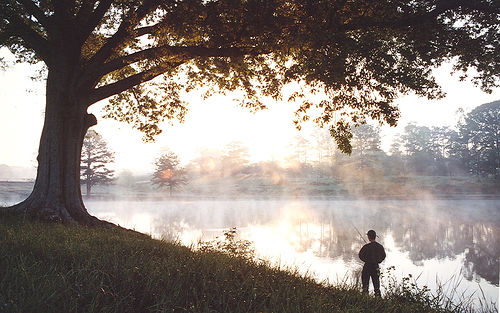

In [ ]:
img

In [ ]:
# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
  print(f"{100 * value.item():.2f}%\t: {data_text.iloc[index.item()]['caption']}")


Top predictions:

12.38%	: A man fishing near a large tree .
11.99%	: A man fishes by a tree in the morning mist .
9.34%	: A hiker is shadowed by the time of day near an open and tree-lined body of water .
5.00%	: Man fly fishing in a small river with steam in the background .
4.41%	: A man fishes under a large tree .


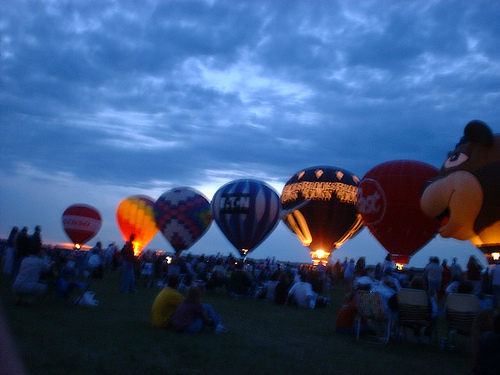

In [ ]:
img = Image.open("/content/drive/MyDrive/CS336/data/Images/107318069_e9f2ef32de.jpg")
img

In [ ]:
image_input = preprocess(img).unsqueeze(0).to(device)

In [ ]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
  print(f"{100 * value.item():.2f}%\t: {data_text.iloc[index.item()]['caption']}")


Top predictions:

83.06%	: Seven large balloons are lined up at nighttime near a crowd .
11.96%	: A group of hot air balloons lit up at night .
2.93%	: A crowd watching air balloons at night .
0.60%	: people next to a red , white and blue hot air balloon that is on the grass
0.45%	: A crowd of people is standing around a red , white and blue hot air balloon as it is readied to launch into the blue sky .


## Zero-Shot Prediction Text to Pic

In [ ]:
caption = "At a beach , a man in an vest tosses a young child into the air"

In [ ]:
folder_path = '/content/drive/MyDrive/CS336/data/Images'
file_list = os.listdir(folder_path)
file_list = [file for file in file_list if file.endswith('.jpg')]

In [ ]:
images = []
count = 0
for file_name in file_list:
    if count == 2000: break
    count += 1

    file_path = os.path.join(folder_path, file_name)
    img = Image.open(file_path)
    images.append(img)

In [ ]:
image_input = torch.cat([preprocess(img).unsqueeze(0) for img in images]).to(device)
text_inputs = torch.cat([clip.tokenize(caption)]).to(device)

In [ ]:
print(image_input.shape)
print(text_inputs.shape)

torch.Size([2000, 3, 224, 224])
torch.Size([1, 77])


In [ ]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

In [ ]:
print(image_features.shape)
print(text_features.shape)

torch.Size([2000, 512])
torch.Size([1, 512])


In [ ]:
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * text_features @ image_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

Caption:  At a beach , a man in an vest tosses a young child into the air

Top predictions:

Ratio given by the machine: 93.75%
----------------------------


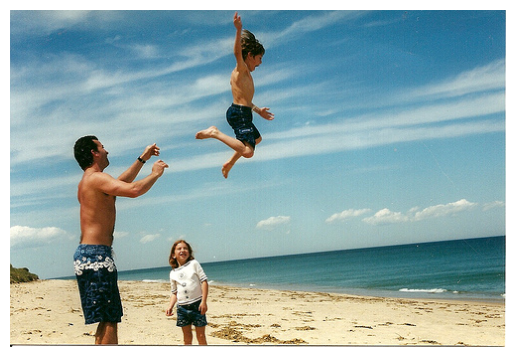

Ratio given by the machine: 1.72%
----------------------------


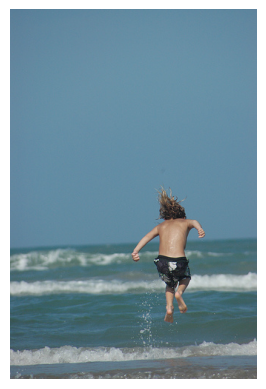

Ratio given by the machine: 0.49%
----------------------------


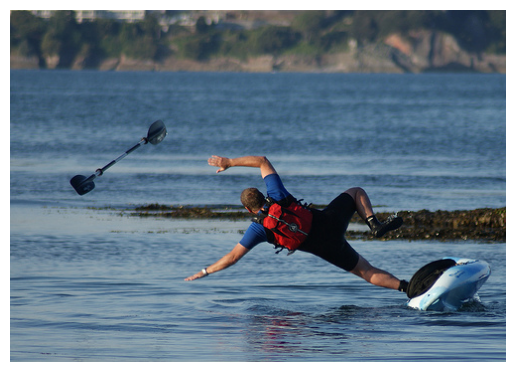

Ratio given by the machine: 0.49%
----------------------------


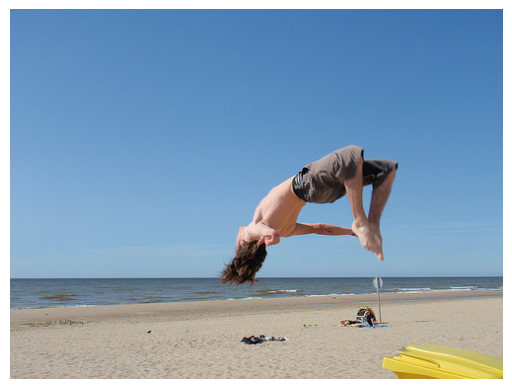

Ratio given by the machine: 0.38%
----------------------------


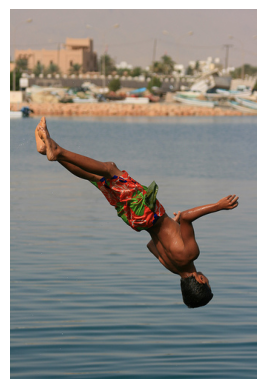

In [ ]:
import matplotlib.pyplot as plt

print("Caption: ", caption)
print("\nTop predictions:\n")
for value, index in zip(values, indices):
  print(f"Ratio given by the machine: {100 * value.item():.2f}%")
  print('----------------------------')
  plt.imshow(images[index.item()])
  plt.axis('off')
  plt.show()

In [ ]:
caption = 'The dogs run in the flower garden'
text_inputs = torch.cat([clip.tokenize(caption)]).to(device)

Caption:  The dogs run in the flower garden

Top predictions:

Ratio given by the machine: 7.62%
----------------------------


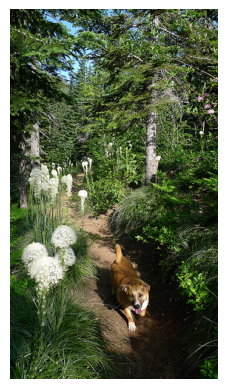

Ratio given by the machine: 5.16%
----------------------------


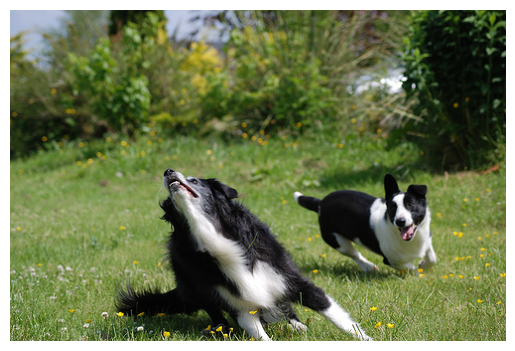

Ratio given by the machine: 4.62%
----------------------------


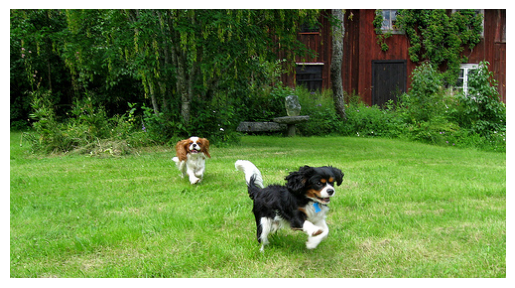

Ratio given by the machine: 4.28%
----------------------------


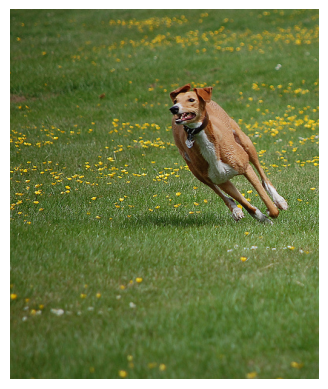

Ratio given by the machine: 3.83%
----------------------------


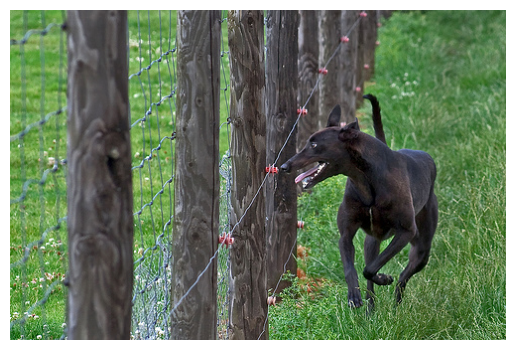

In [ ]:
# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * text_features @ image_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

import matplotlib.pyplot as plt

print("Caption: ", caption)
print("\nTop predictions:\n")
for value, index in zip(values, indices):
  print(f"Ratio given by the machine: {100 * value.item():.2f}%")
  print('----------------------------')
  plt.imshow(images[index.item()])
  plt.axis('off')  # Tắt trục
  plt.show()

In [21]:
caption = 'two men climbing a mountain'
text_inputs = torch.cat([clip.tokenize(caption)]).to(device)

Caption:  two men climbing a mountain

Top predictions:

Ratio given by the machine: 18.08%
----------------------------


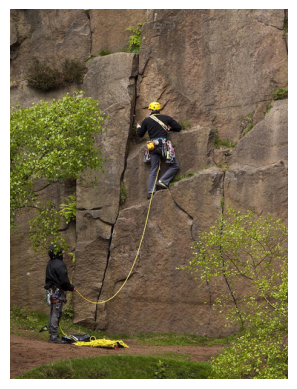

Ratio given by the machine: 12.62%
----------------------------


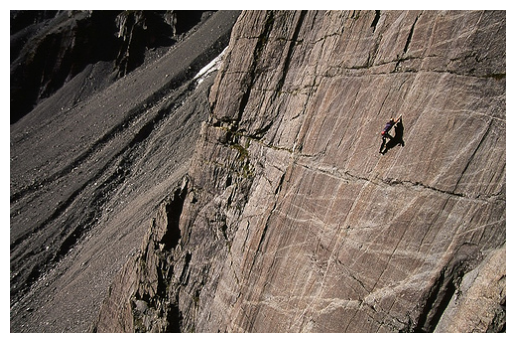

Ratio given by the machine: 7.78%
----------------------------


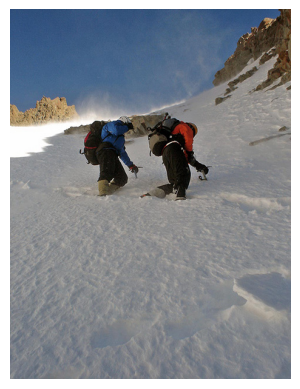

Ratio given by the machine: 7.20%
----------------------------


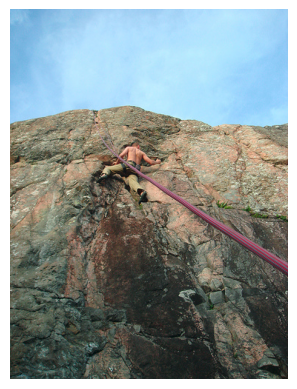

Ratio given by the machine: 4.57%
----------------------------


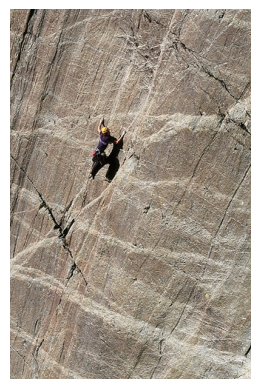

In [22]:
# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * text_features @ image_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

import matplotlib.pyplot as plt

print("Caption: ", caption)
print("\nTop predictions:\n")
for value, index in zip(values, indices):
  print(f"Ratio given by the machine: {100 * value.item():.2f}%")
  print('----------------------------')
  plt.imshow(images[index.item()])
  plt.axis('off')  # Tắt trục
  plt.show()